In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [173]:
df = pd.read_csv('/content/training_NYC.csv')
df.shape

(48678, 11)

In [174]:
#model_3

#       - LOAD TYPES -

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], errors='coerce')

#       - FEATURE DATE -
df['SALE_MONTH'] = df['SALE_DATE'].dt.month

#       - LIMPIEZA Y PREPARACIÓN -

df_model = df[df['SALE_PRICE'].notna() & (df['SALE_PRICE'] > 0)]

#       - Outliers -

q_low = df_model['GROSS_SQUARE_FEET'].quantile(0.01)
q_high = df_model['GROSS_SQUARE_FEET'].quantile(0.99)
df_model = df_model[(df_model['GROSS_SQUARE_FEET'] >= q_low) & (df_model['GROSS_SQUARE_FEET'] <= q_high)]

q_low_price = df_model['SALE_PRICE'].quantile(0.01)
q_high_price = df_model['SALE_PRICE'].quantile(0.99)
df_model = df_model[(df_model['SALE_PRICE'] >= q_low_price) & (df_model['SALE_PRICE'] <= q_high_price)]

#       - Transformación -

df_model['SALE_PRICE'] = np.log1p(df_model['SALE_PRICE'])
df_model['GROSS_SQUARE_FEET'] = np.log1p(df_model['GROSS_SQUARE_FEET'])

#       - características -
features = ['BOROUGH', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
            'season', 'TAX_CLASS_AT_TIME_OF_SALE', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'SALE_MONTH']

target = 'SALE_PRICE'
X = df_model[features]
y = df_model[target]

#       - Separación de conjuntos -
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical = ['BUILDING_CLASS_AT_TIME_OF_SALE', 'season', 'TAX_CLASS_AT_TIME_OF_SALE','ZIP_CODE','YEAR_BUILT', 'SALE_MONTH','RESIDENTIAL_UNITS']
numerical = ['BOROUGH', 'GROSS_SQUARE_FEET',]

#       - PREPROCESAMIENTO -
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)])

#       - RANDOM FOREST -
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

#       - VALIDACIÓN CRUZADA -

scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"CV RMSE promedio: ${-scores.mean():,.2f}")

#       - Pipeline -
pipeline.fit(X_train, y_train)

#       - Evaluación -
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE del modelo: ${rmse:,.2f}")


# -------- PREDICCIÓN --------
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"RMSE del modelo en dólares: ${rmse_real:,.2f}")


#         - Guardado -
joblib.dump(pipeline, 'sales_predictor.pkl')


CV RMSE promedio: $0.59
RMSE del modelo: $0.44
RMSE del modelo en dólares: $566,784.08


['sales_predictor.pkl']

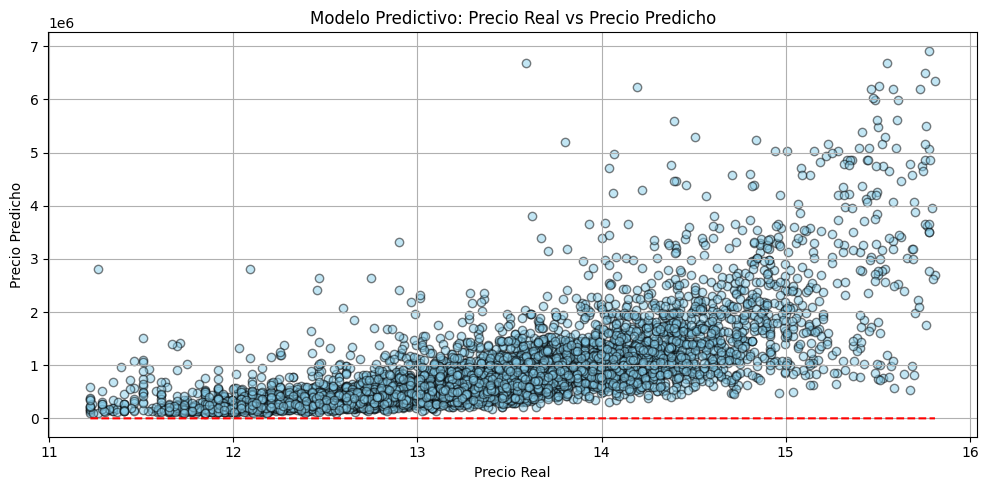

In [175]:
# - Evaluación del Modelo (Predicción vs Real) -

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='skyblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Modelo Predictivo: Precio Real vs Precio Predicho')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()

In [176]:
#       - TESTER -

model = joblib.load('sales_predictor.pkl')
property_search = pd.DataFrame([{
    'BOROUGH': 2,
    'BUILDING_CLASS_AT_TIME_OF_SALE': 'D1',
    'GROSS_SQUARE_FEET': np.log1p(2000),
    'YEAR_BUILT': 1950,
    'season': '1',
    'TAX_CLASS_AT_TIME_OF_SALE': '1',
    'ZIP_CODE': 10001,
    'RESIDENTIAL_UNITS': 1,
    'SALE_MONTH': 1,
    }])

log_prediccion = model.predict(property_search)[0]
output_predictor = np.expm1(log_prediccion)

print(f"Precio estimado de venta: ${output_predictor:,.2f}")

Precio estimado de venta: $469,562.17


In [ ]:
from google.colab import files
files.download('sales_predictor.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>